In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from os import listdir
from os.path import isfile, join

import sys
sys.path.append('..')

import src as odyn

# Recreate JAMA Results

In this notebook we show the model parameters required to recret the results from [Siegler et al.](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2784480).  

<img src="Siegler_sankey.png" alt="drawing" width="400"/> 

Scripts to recreate models results are found in `scripts/jama_simulation.py`, although the basic functionality of that script can be found below.  

In [2]:
model = odyn.OpinionNetworkModel(probabilities = [.69, .31],
                                power_law_exponent = 1.5,
                                openness_to_neighbors = 1.5,
                                openness_to_influencers = 1.5,
                                distance_scaling_factor = 1/10,
                                importance_of_weight = 2, 
                                importance_of_distance = 8,
                                left_reach = .35,  #set left influencer reach
                                right_reach = .75, #set right influencer reach
                                include_opinion = True,
                                include_weight = True,
                                include_distance = True)

model.agent_df = model.add_random_agents_to_triangle(num_agents = 1000,show_plot = False)

# See Initial Beliefs
hesitant = 0
while hesitant != 31:
    model.belief_df = model.assign_weights_and_beliefs(model.agent_df)
    hesitant = int(np.sum(model.belief_df["belief"] > 0)/model.belief_df.shape[0] * 100)

# Build Network Connections
prob_df = model.compute_probability_array(model.belief_df)
model.adjacency_df = model.compute_adjacency(prob_df)
model.mega_influencer_df = model.connect_mega_influencers(model.belief_df)

# Run Simulations
sim = odyn.NetworkSimulation()
sim.run_simulation(model = model, stopping_thresh = 0.01, show_plot = False, store_results = False)

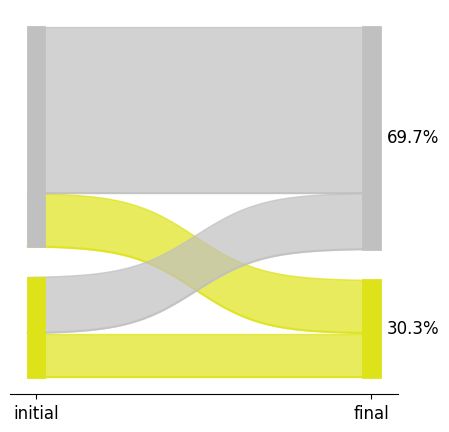

In [3]:
fig, ax = plt.subplots(figsize = (5,5), sharex = True, sharey = True)
axis = odyn.get_alluvial_plot_axis(ax = ax, dynamic_belief_df = sim.dynamic_belief_df, 
                      vaccination_threshold = -1, 
                     hesitant_threshold = 0)

plt.show()

We recreate the axis array for different left/right reach configurations below.

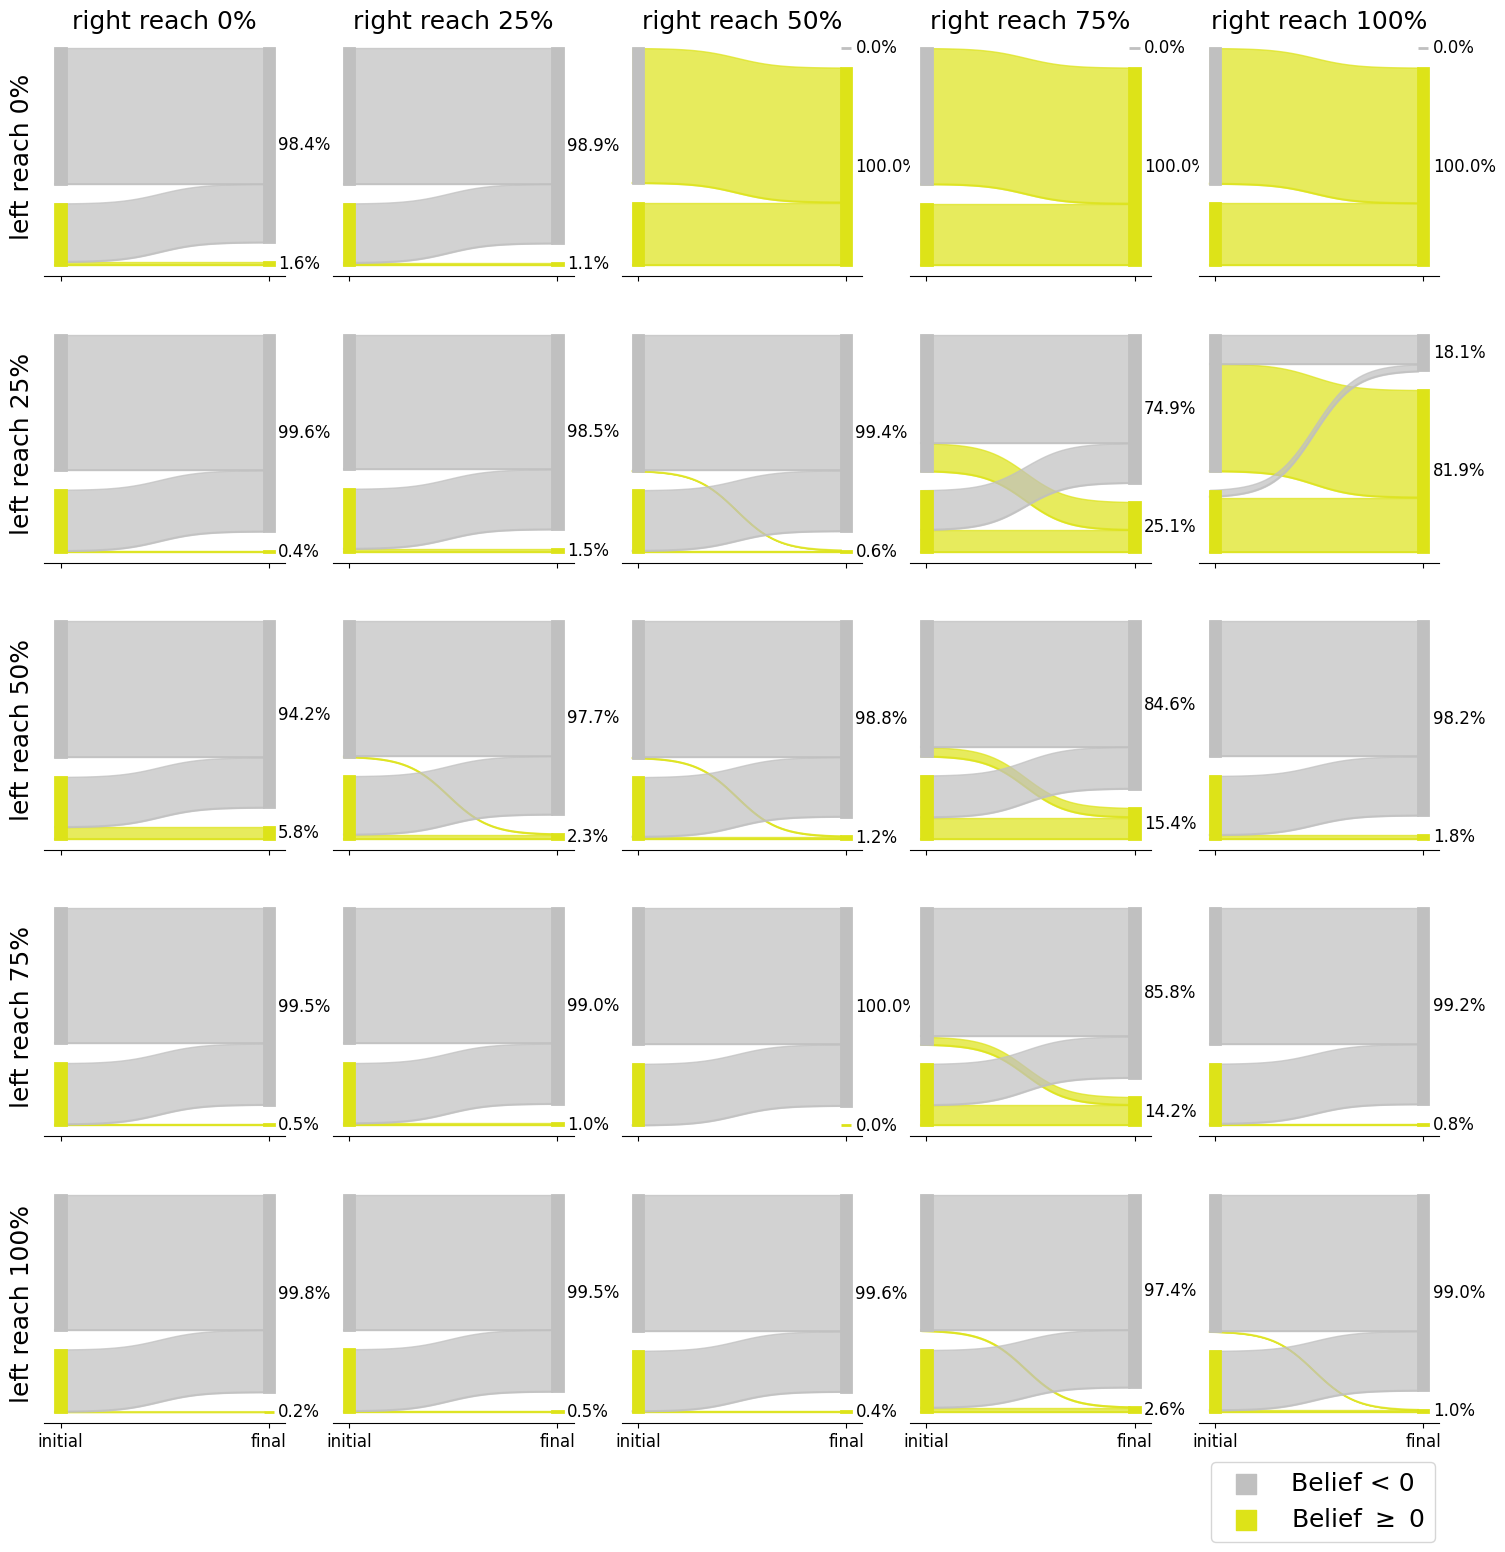

In [4]:
folder = "../data/simulation_results_from_paper/1000_agent_model_jama"
trial = "01"

fig, ax = plt.subplots(5,5,figsize = (18,18), sharex = True, sharey = True)
for left in ["000","025","050","075","100"]:
    for right in ["000","025","050","075","100"]:
        subfolder = f"{folder}/left_reach_{left}_right_reach_{right}"
        try:
            file = f"{subfolder}/{trial}_dynamic_belief_df.csv"
            dynamic_belief_df = pd.read_csv(file, index_col = 0)
            dynamic_belief_df.rename(columns = {c:int(c) for c in dynamic_belief_df.columns}, inplace = True)
            hesitant_threshold = dynamic_belief_df[0].sort_values().reset_index(drop = True).iloc[int(dynamic_belief_df.shape[0] * .69)]
            l = int(left)
            r = int(right)
            axis = ax[int(l/25), int(r/25)]
            if r == 0:
                axis.set_ylabel(f"left reach {l}%", fontsize = 18)
            if l == 0:
                axis.set_title(f"right reach {r}%", fontsize = 18)
            axis = odyn.get_alluvial_plot_axis(ax = axis, dynamic_belief_df = dynamic_belief_df, 
                              vaccination_threshold = -1, 
                             hesitant_threshold = 0)
        except:
            pass
plt.scatter([],[], color = "silver", marker = "s", s = 200, label = r"Belief < 0")
plt.scatter([],[], color = "#DDE318", marker = "s", s = 200, label = r"Belief $\geq$ 0")

plt.legend(fontsize = 18, loc = "lower left", bbox_to_anchor = (0,-.55))
plt.show()

In [10]:
def compute_95_conf(a):
    degrees_of_freedom = len(a) -1
    t = np.abs(st.t.ppf((1-.95)/2, degrees_of_freedom))
    I_min = np.around(a.mean() - a.std()*t/np.sqrt(len(a)), decimals = 1)
    I_max = np.around(a.mean() + a.std()*t/np.sqrt(len(a)), decimals = 1)
    return (I_min,I_max)

folder = "../data/simulation_results_from_paper/1000_agent_model_jama/left_reach_035_right_reach_075"
willing = []
hesitant = []
willing_to_hesitant = []
hesitant_to_willing = []
for i in range(30):
    trial = f"{i:02}"
    try:
        df = pd.read_csv( f"{folder}/{trial}_dynamic_belief_df.csv", index_col = 0)
        df.rename(columns = {c:int(c) for c in df.columns}, inplace = True)
        willing.append((df.iloc[:,0] < 0).sum())
        willing_to_hesitant.append(((df.iloc[:,0] < 0) & (df.iloc[:,-1] > 0)).sum())
        hesitant_to_willing.append(((df.iloc[:,0] > 0) & (df.iloc[:,-1] < 0)).sum())
    except: 
        pass
    
willing = np.array(willing)
hesitant = 1000 - willing

df_conf = pd.DataFrame(columns = ["min","max"])

willing_to_hesitant = np.array(willing_to_hesitant)
willing_to_willing = willing - willing_to_hesitant
df_conf.loc["Willing to Willing",:] = list(compute_95_conf((100 * willing_to_willing/willing)))
df_conf.loc["Willing to Hesitant",:] = list(compute_95_conf((100 * willing_to_hesitant/willing)))

hesitant_to_willing = np.array(hesitant_to_willing)
hesitant_to_hesitant = hesitant - hesitant_to_willing
df_conf.loc["Hesitant to Willing",:] = list(compute_95_conf((100 * hesitant_to_willing/hesitant)))
df_conf.loc["Hesitant to Hesitant",:] = list(compute_95_conf((100 * hesitant_to_hesitant/hesitant)))

df_conf

,min,max
Willing to Willing,69.4,87.1
Willing to Hesitant,12.9,30.6
Hesitant to Willing,46.9,69.2
Hesitant to Hesitant,30.8,53.1


In [11]:
df_conf_jama = pd.DataFrame(columns = ["min","max"])
df_conf_jama.loc["Willing to Willing"] = [50 + 36,57 + 43]
df_conf_jama.loc["Willing to Hesitant"] = [5,9]
df_conf_jama.loc["Hesitant to Willing"] = [27 + 32, 37 + 42]
df_conf_jama.loc["Hesitant to Hesitant"] = [27,37]
df_conf_jama

,min,max
Willing to Willing,86,100
Willing to Hesitant,5,9
Hesitant to Willing,59,79
Hesitant to Hesitant,27,37


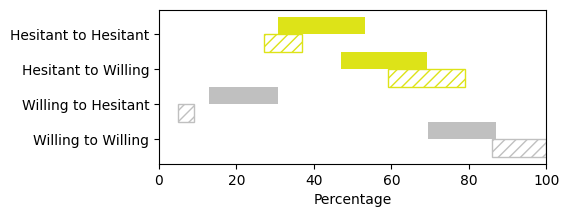

In [12]:
fig, ax = plt.subplots(figsize = (5,2))
ax.set_xlim(0,100)
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(list(df_conf.index))
ax.set_xlabel("Percentage")

vert_pos = np.array([1,2,3,4])

ax.barh(vert_pos + .25, width = df_conf["max"] - df_conf["min"], left = df_conf["min"], height = .5, color = ["silver","silver","#DDE318","#DDE318"], zorder = 0)

ax.barh(vert_pos - .25,width = df_conf_jama["max"] - df_conf_jama["min"], left = df_conf_jama["min"], height = .5, color = "white", edgecolor = ["silver","silver","#DDE318","#DDE318"], zorder = 0, 
        hatch="///")

plt.show()

In [13]:
dynamic_belief_df_jama = pd.DataFrame(columns = [0,1])
dynamic_belief_df_jama[0] = np.concatenate([np.full(690,-1),np.full(310,1)])

initial_willing = np.concatenate([np.full(641,-1), np.full(49,1)])
initial_hesitant = np.concatenate([np.full(310-101,-1), np.full(101,1)])
dynamic_belief_df_jama[1] = np.concatenate([initial_willing,initial_hesitant])
dynamic_belief_df_jama

,0,1
0,-1,-1
1,-1,-1
2,-1,-1
3,-1,-1
4,-1,-1
...,...,...
995,1,1
996,1,1
997,1,1
998,1,1


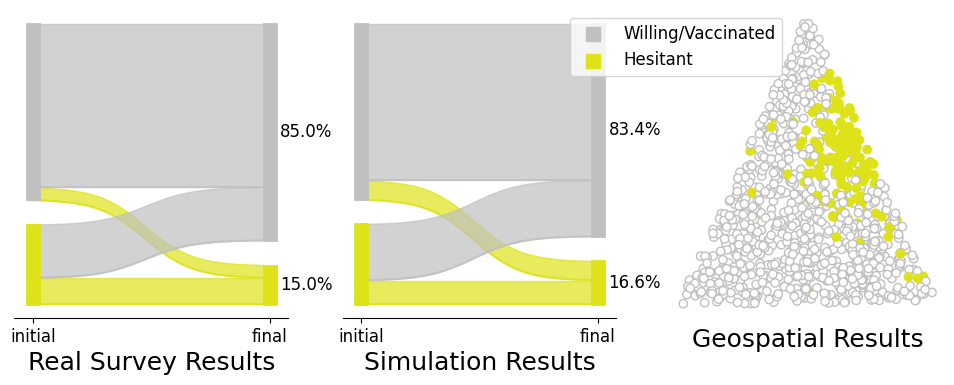

In [14]:
folder = "../data/simulation_results_from_paper/1000_agent_model_jama/left_reach_035_right_reach_075"

fig, ax = plt.subplots(1,3,figsize = (12,4))


belief_df = pd.read_csv(f"{folder}/06_belief_df.csv", index_col = 0)
df = pd.read_csv( f"{folder}/06_dynamic_belief_df.csv", index_col = 0)
df.rename(columns = {c:int(c) for c in df.columns}, inplace = True)


x = belief_df["x"]
y = belief_df["y"]

c = []
e = []
for i in belief_df.index:
    if (df.iloc[i,-1]> 0):
        c.append("#DDE318")
        e.append("#DDE318")
    else:
        c.append("white")
        e.append("silver")
ax[2].scatter(x,y, color = c, edgecolor = e)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].set_xticks([])
ax[2].set_yticks([])
odyn.get_alluvial_plot_axis(ax = ax[1], dynamic_belief_df = df, 
                          vaccination_threshold = -1, 
                         hesitant_threshold = 0)

odyn.get_alluvial_plot_axis(ax = ax[0], dynamic_belief_df = dynamic_belief_df_jama, 
                          vaccination_threshold = -1, 
                         hesitant_threshold = 0)

ax[0].set_xlabel("Real Survey Results", fontsize = 18)
ax[1].set_xlabel("Simulation Results", fontsize = 18)
ax[2].set_xlabel("Geospatial Results", fontsize = 18)

plt.scatter([],[], color = "silver", marker = "s", s = 100, label = r"Willing/Vaccinated")
plt.scatter([],[], color = "#DDE318", marker = "s", s = 100, label = r"Hesitant")
plt.legend(loc = "upper left", bbox_to_anchor = (-0.4,1), fontsize = 12)
plt.show()